# Static Fracture Analysis (SFA) with Python
## ***Instructions to use this notebook***
### 1. Install Anaconda

- Install [anaconda for **Python 3.6**](https://www.anaconda.com/download/) for your OS
- Accept all defaults and add Anaconda to your Path when prompted

### 2. Create environment

It is important to work in a defined environment and to ensure all packages are installed and run in that environement, to that end run the following commands in a terminal, in your working directory for this notebook:

`conda config --add channels conda-forge` This 'channel' will now always be available in your environments

`conda create -n fracs python=3.6` To create an environment called 'fracs' using Python3.6

`conda activate fracs` To activate the 'fracs' environment (which you can leave with `conda deactivate`)

### 3. Install packages to environment

While still in the 'fracs' environment , install the following packages (other packages can be installed later):

`conda install -c conda-forge pandas matplotlib numpy ipython`

`pip install xlrd`

### 4. Enable environment in jupyter notebooks and launch

`python -m ipykernel install --name fracs --display-name "fracs"` To enable the environment

`jupyter notebook` To launch the notebook in a browser

Then create a new notebook using the 'fracs' kernel

### 5. Library imports

In [1]:
# these warning filters are needed for a numpy error
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed") # due a RuntimeWarning with numpy.dtype
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from utils import *
from mpl_toolkits.mplot3d import Axes3D
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import mplstereonet
from welly import Well
from IPython.display import HTML
import welly.quality as qty

In [2]:
# installed packages
installed_packages = [
    pd,
    np,
    mpl,
    widgets,
    mplstereonet
]

In [3]:
# check installed packages
for package in installed_packages:
    print(f'Package: {package.__name__}\nVersion: ' + package.__version__ + '\n')

Package: pandas
Version: 0.23.4

Package: numpy
Version: 1.15.0

Package: matplotlib
Version: 2.2.3

Package: ipywidgets
Version: 7.4.0

Package: mplstereonet
Version: 0.5



### 6. Data import and cleaning

In [4]:
# import data
# well survey
survey = pd.read_csv('../data/HEF_image_interp/for_HEF/Well_Surveys_Projected_to_TD.csv', header=4)
# well tops
tops = pd.read_excel('../data/HEF_image_interp/for_HEF/Well_Formations.xlsx')
# image data
image_data = pd.read_csv('../data/HEF_image_interp/ASCII_n_LAS/well_1D_all.txt',skiprows=(1,2))
# well logs
log_data = Well.from_las('../data/wellOpsData/Subsurface/Petrophysics/well_las.las')

In [5]:
# clean up survey
# drop NaN
survey_edt = survey.dropna(how='all')
survey_edt = survey_edt.dropna(axis='columns', how='all')
survey_edt.head()

,MD[m],Inc[deg],Azi[deg],TVD[m],North[m],East[m],Dogleg [deg/30m],Vertical Section[m]
0,0,0.0,0.00,0.00,0.00,0.00,NaN,0.00
1,76.29,0.9,7.19,76.29,0.59,0.07,0.35,0.26
2,104.36,0.9,17.20,104.35,1.02,0.17,0.17,0.41
3,134,0.9,15.59,133.99,1.47,0.30,0.03,0.53
4,162.73,1.1,6.39,162.72,1.96,0.39,0.27,0.72


In [6]:
survey_edt.tail(2)

,MD[m],Inc[deg],Azi[deg],TVD[m],North[m],East[m],Dogleg [deg/30m],Vertical Section[m]
79,2267.00,35.43,298.39,2013.3,498.84,-797.35,0.29,940.51
82,All data is in Metres unless otherwise stated\...,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Copy survey information from survey dataframe and save to seperate dataframe
survey_info = survey_edt[-1:]
survey_info = survey_info.drop(columns=list(survey_edt)[1:],inplace=False)
survey_info.rename(index=str, columns={"MD[m]": "Survey Info"}, inplace=True)
survey_info.reset_index(inplace=True, drop=True)
survey_info

,Survey Info
0,All data is in Metres unless otherwise stated\...


In [8]:
# Delete Survey information from survey dataframe
survey_edt = survey_edt[:-1]
survey_edt.tail()

,MD[m],Inc[deg],Azi[deg],TVD[m],North[m],East[m],Dogleg [deg/30m],Vertical Section[m]
75,2171.08,35.90,298.69,1935.50,472.03,-748.06,0.33,884.53
76,2199.36,36.00,298.69,1958.40,480.00,-762.62,0.11,901.10
77,2228.15,35.80,298.39,1981.72,488.07,-777.45,0.28,917.10
78,2248.73,35.80,298.49,1998.43,493.79,-788.01,0.30,929.93
79,2267.00,35.43,298.39,2013.30,498.84,-797.35,0.29,940.51


In [9]:
# convert data to floats
survey_edt = survey_edt.apply(pd.to_numeric)

In [10]:
tops.head(3)

,DD-11 Formations,Unnamed: 1,Unnamed: 2,Unnamed: 3,YMT Comments
0,MD,TVD,Formations,Log Tops,Remarks
1,5.5,5.5,Lower Bakhtiari,5.5,No Gamma
2,445,441.37,Upper Fars,445,No Gamma


In [11]:
# Clean up tops
tops.columns = tops.iloc[0]
tops.drop(columns=['Log Tops', 'Remarks'], inplace=True)
tops.drop([0], inplace=True)
tops.reset_index(inplace=True, drop=True)
tops = tops.apply(pd.to_numeric, errors='ignore')
tops

,MD,TVD,Formations
0,5.50,5.50,Lower Bakhtiari
1,445.00,441.37,Upper Fars
2,810.00,770.91,Lower Fars
3,1150.00,1065.27,Pila Spi
4,1318.00,1210.50,Gercus
5,1372.00,1257.41,Sinjar
6,1495.00,1364.37,Kolosh
7,1885.00,1699.87,Shiranish
8,2032.00,1822.94,Kometan
9,2049.01,1836.73,Upper Qamchuqa


In [12]:
image_data.head()

,#DEPTH DIP AZIM QUAL DEVI HAZI AAZI ADIP DIPTYPE
0,1886.85 5.5 321.8 1.00 30.9 262.4 27...
1,1887.40 12.9 329.4 1.00 30.8 257.0 27...
2,1887.97 6.7 326.7 1.00 30.9 255.0 26...
3,1888.53 10.5 320.5 1.00 30.8 263.3 27...
4,1889.34 6.7 336.3 1.00 30.8 298.0 30...


In [13]:
headers = image_data.columns.values

In [14]:
headers = headers[0].split()
headers

['#DEPTH', 'DIP', 'AZIM', 'QUAL', 'DEVI', 'HAZI', 'AAZI', 'ADIP', 'DIPTYPE']

In [15]:
image_data = image_data['#DEPTH  DIP    AZIM   QUAL   DEVI   HAZI   AAZI   ADIP      DIPTYPE'].str.split(n=None,expand=True)

In [16]:
image_data.head()

,0,1,2,3,4,5,6,7,8,9
0,1886.85,5.5,321.8,1.00,30.9,262.4,270.8,34.0,BED,None
1,1887.40,12.9,329.4,1.00,30.8,257.0,277.8,36.6,BED,None
2,1887.97,6.7,326.7,1.00,30.9,255.0,266.5,33.5,BED,None
3,1888.53,10.5,320.5,1.00,30.8,263.3,277.8,37.4,BED,None
4,1889.34,6.7,336.3,1.00,30.8,298.0,305.0,36.3,BED,None


In [17]:
image_data.fillna(value='',inplace=True)
image_data.head()

,0,1,2,3,4,5,6,7,8,9
0,1886.85,5.5,321.8,1.00,30.9,262.4,270.8,34.0,BED,
1,1887.40,12.9,329.4,1.00,30.8,257.0,277.8,36.6,BED,
2,1887.97,6.7,326.7,1.00,30.9,255.0,266.5,33.5,BED,
3,1888.53,10.5,320.5,1.00,30.8,263.3,277.8,37.4,BED,
4,1889.34,6.7,336.3,1.00,30.8,298.0,305.0,36.3,BED,


In [18]:
image_data[8] = image_data[8] + image_data[9]
image_data.drop(columns=[9], inplace=True)
image_data.columns = headers
image_data = image_data.apply(pd.to_numeric, errors='ignore')
image_data.head()

,#DEPTH,DIP,AZIM,QUAL,DEVI,HAZI,AAZI,ADIP,DIPTYPE
0,1886.85,5.5,321.8,1.0,30.9,262.4,270.8,34.0,BED
1,1887.40,12.9,329.4,1.0,30.8,257.0,277.8,36.6,BED
2,1887.97,6.7,326.7,1.0,30.9,255.0,266.5,33.5,BED
3,1888.53,10.5,320.5,1.0,30.8,263.3,277.8,37.4,BED
4,1889.34,6.7,336.3,1.0,30.8,298.0,305.0,36.3,BED


### 7. Cleaned data export for backup

In [19]:
# export cleaned data to csv
survey_edt.to_csv('../data/cleanedData/survey_edt.csv',sep=',')
survey_info.to_csv('../data/cleanedData/survey_info.csv',sep=',')
tops.to_csv('../data/cleanedData/tops.csv',sep=',')
image_data.to_csv('../data/cleanedData/image_data.csv',sep=',')

### 8. Exploratory data analysis

#### 8.1 Well deviation survey

In [20]:
#survey_edt, survey_info, tops, image_data
survey_edt[39:42]

,MD[m],Inc[deg],Azi[deg],TVD[m],North[m],East[m],Dogleg [deg/30m],Vertical Section[m]
39,1143.36,30.3,297.79,1059.55,205.14,-283.44,0.75,349.23
40,1171.49,30.3,297.79,1083.83,211.76,-296.00,0.00,363.38
41,1199.59,30.5,297.69,1108.07,218.38,-308.58,0.22,377.55


In [21]:
survey_info['Survey Info'][0]

"All data is in Metres unless otherwise stated\r\nCoordinates are from Installation MD's are from Rig and TVD's are from Rig ( Actual Datum #1 430.1m above Mean Sea Level )\r\nVertical Section is from 0.00N 0.00E on azimuth 302.380 degrees\r\nBottom hole distance is 901.11 Metres on azimuth 302.19 degrees from Wellhead\r\nCalculation method uses Minimum Curvature method"

In [22]:
# get xyz arrays for survey
x_dev = mdia_to_xyz_minCurve('../data/cleanedData/survey_edt.csv')[0]
y_dev = mdia_to_xyz_minCurve('../data/cleanedData/survey_edt.csv')[1]
z_dev = mdia_to_xyz_minCurve('../data/cleanedData/survey_edt.csv')[2]

In [23]:
x_pos = []
x_temp = 0
for line in x_dev:
    x_temp += line
    x_pos.append(x_temp)

y_pos = []    
y_temp = 0
for line in y_dev:
    y_temp += line
    y_pos.append(y_temp)

z_pos = []
z_temp = 0
for line in z_dev:
    z_temp += line
    z_pos.append(-1 * z_temp)

In [24]:
survey_edt.head(3)

,MD[m],Inc[deg],Azi[deg],TVD[m],North[m],East[m],Dogleg [deg/30m],Vertical Section[m]
0,0.00,0.0,0.00,0.00,0.00,0.00,NaN,0.00
1,76.29,0.9,7.19,76.29,0.59,0.07,0.35,0.26
2,104.36,0.9,17.20,104.35,1.02,0.17,0.17,0.41


In [25]:
# add np.nan value at 0-index to get equal length with survey
x_pos.insert(0,np.nan)
y_pos.insert(0,np.nan)
z_pos.insert(0,np.nan)

In [26]:
# add new column to df
survey_edt['x[m]'] = x_pos
survey_edt['y[m]'] = y_pos
survey_edt['z[m]'] = z_pos
survey_edt.head()

,MD[m],Inc[deg],Azi[deg],TVD[m],North[m],East[m],Dogleg [deg/30m],Vertical Section[m],x[m],y[m],z[m]
0,0.00,0.0,0.00,0.00,0.00,0.00,NaN,0.00,NaN,NaN,NaN
1,76.29,0.9,7.19,76.29,0.59,0.07,0.35,0.26,0.074991,0.594446,-76.285531
2,104.36,0.9,17.20,104.35,1.02,0.17,0.17,0.41,0.167772,1.023758,-104.352089
3,134.00,0.9,15.59,133.99,1.47,0.30,0.03,0.53,0.299168,1.470349,-133.988433
4,162.73,1.1,6.39,162.72,1.96,0.39,0.27,0.72,0.390501,1.961742,-162.714067


In [27]:
survey_edt[38:42]

,MD[m],Inc[deg],Azi[deg],TVD[m],North[m],East[m],Dogleg [deg/30m],Vertical Section[m],x[m],y[m],z[m]
38,1114.51,29.9,298.99,1034.59,198.26,-270.71,0.77,334.80,-270.714105,198.263451,-1034.591116
39,1143.36,30.3,297.79,1059.55,205.14,-283.44,0.75,349.23,-283.442416,205.141716,-1059.550939
40,1171.49,30.3,297.79,1083.83,211.76,-296.00,0.00,363.38,-295.997864,211.758653,-1083.838255
41,1199.59,30.5,297.69,1108.07,218.38,-308.58,0.22,377.55,-308.583153,218.377247,-1108.074882


In [28]:
@interact(azimuth=widgets.IntSlider(min=0,max=360,step=5,value=270)
          , elevation=widgets.IntSlider(min=0,max=90,step=5,value=90))
def rotate(azimuth, elevation):
    """
    displays the well trajectory in 3D
    default view is from top with North at top
    """
    # set up 
    mpl.rcParams['legend.fontsize'] = 12
    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(projection='3d')

    # pass data
    x = x_pos
    y = y_pos
    z = z_pos

    # define plot
    ax.plot(x, y, z, label='Well deviation')
    ax.legend(loc=0)
    ax.view_init(elev = elevation, azim=azimuth)
    plt.show()
    return

interactive(children=(IntSlider(value=270, description='azimuth', max=360, step=5), IntSlider(value=90, descri…

#### 8.2 Well tops

In [29]:
tops

,MD,TVD,Formations
0,5.50,5.50,Lower Bakhtiari
1,445.00,441.37,Upper Fars
2,810.00,770.91,Lower Fars
3,1150.00,1065.27,Pila Spi
4,1318.00,1210.50,Gercus
5,1372.00,1257.41,Sinjar
6,1495.00,1364.37,Kolosh
7,1885.00,1699.87,Shiranish
8,2032.00,1822.94,Kometan
9,2049.01,1836.73,Upper Qamchuqa


In [30]:
survey_edt.head()

,MD[m],Inc[deg],Azi[deg],TVD[m],North[m],East[m],Dogleg [deg/30m],Vertical Section[m],x[m],y[m],z[m]
0,0.00,0.0,0.00,0.00,0.00,0.00,NaN,0.00,NaN,NaN,NaN
1,76.29,0.9,7.19,76.29,0.59,0.07,0.35,0.26,0.074991,0.594446,-76.285531
2,104.36,0.9,17.20,104.35,1.02,0.17,0.17,0.41,0.167772,1.023758,-104.352089
3,134.00,0.9,15.59,133.99,1.47,0.30,0.03,0.53,0.299168,1.470349,-133.988433
4,162.73,1.1,6.39,162.72,1.96,0.39,0.27,0.72,0.390501,1.961742,-162.714067


In [31]:
tops = top_incAziXYZ(tops, survey_edt)
tops

,MD,TVD,Formations,Inc[deg],Azi[deg],x[m],y[m],z[m]
0,5.50,5.50,Lower Bakhtiari,0.064884,0.518351,NaN,NaN,NaN
1,445.00,441.37,Upper Fars,14.782877,324.611918,-11.565505,38.615367,-441.374055
2,810.00,770.91,Lower Fars,29.908803,303.971338,-139.890420,120.326525,-770.918182
3,1150.00,1065.27,Pila Spi,30.300000,297.790000,-286.406091,206.703623,-1065.283885
4,1318.00,1210.50,Gercus,29.791073,298.481073,-360.870122,246.547294,-1210.511194
5,1372.00,1257.41,Sinjar,29.604817,298.390000,-384.401244,259.278395,-1257.417506
6,1495.00,1364.37,Kolosh,29.311869,299.629836,-437.467897,288.805234,-1364.378610
7,1885.00,1699.87,Shiranish,31.435415,301.506681,-607.243979,392.443458,-1699.714699
8,2032.00,1822.94,Kometan,35.625881,299.270589,-676.638045,432.866375,-1822.781381
9,2049.01,1836.73,Upper Qamchuqa,35.889500,299.072875,-685.328848,437.711419,-1836.577584


In [32]:
@interact(azimuth=widgets.IntSlider(min=0,max=360,step=5,value=270)
          , elevation=widgets.IntSlider(min=0,max=90,step=5,value=90))
def rotate(azimuth, elevation):
    """
    displays the well trajectory in 3D
    default view is from top with North at top
    """
    # set up 
    mpl.rcParams['legend.fontsize'] = 12
    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(projection='3d')

    # pass data
    x = x_pos
    y = y_pos
    z = z_pos
    tops_x = tops['x[m]'].replace(np.nan, 0).tolist()
    tops_y = tops['y[m]'].replace(np.nan, 0).tolist()
    tops_z = tops['z[m]'].replace(np.nan, 0).tolist()
    top_names = tops['Formations'].tolist()
    m = np.array([tops_x,tops_y, tops_z])
    m = np.where(np.isfinite(m), m, 0)
    # define plot
    ax.plot(x, y, z, label='Well deviation')
    ax.legend(loc=0)
    ax.set_xlabel('Easting[m] from kb', labelpad=10)
    ax.set_ylabel('Northing[m] from kb', labelpad=10)
    ax.set_zlabel('TVD below datum', labelpad=10)
    
    for top_names, x, y, z, in zip(top_names, tops_x, tops_y, tops_z):
        ax.scatter3D(tops_x, tops_y, tops_z, s=50, c='red')
        ax.text3D(x,y,z, f'{top_names}')
        
    ax.view_init(elev = elevation, azim=azimuth)
    plt.show()
    return

interactive(children=(IntSlider(value=270, description='azimuth', max=360, step=5), IntSlider(value=90, descri…

#### 8.3 Fracture data

In [33]:
image_data.shape

(822, 9)

In [34]:
image_data.head()

,#DEPTH,DIP,AZIM,QUAL,DEVI,HAZI,AAZI,ADIP,DIPTYPE
0,1886.85,5.5,321.8,1.0,30.9,262.4,270.8,34.0,BED
1,1887.40,12.9,329.4,1.0,30.8,257.0,277.8,36.6,BED
2,1887.97,6.7,326.7,1.0,30.9,255.0,266.5,33.5,BED
3,1888.53,10.5,320.5,1.0,30.8,263.3,277.8,37.4,BED
4,1889.34,6.7,336.3,1.0,30.8,298.0,305.0,36.3,BED


In [35]:
diptype_counts = image_data.groupby(["DIPTYPE"]).count()
diptype_counts

,#DEPTH,DIP,AZIM,QUAL,DEVI,HAZI,AAZI,ADIP
DIPTYPE,,,,,,,,
BED,611,611,611,611,611,611,611,611
BED_LOW_CONF,22,22,22,22,22,22,22,22
BREAKOUT,5,5,5,5,5,5,5,5
DRILL.IND.FRAC.,15,15,15,15,15,15,15,15
FRACTURE,62,62,62,62,62,62,62,62
HEALEDFRACTURE,107,107,107,107,107,107,107,107


In [36]:
image_data.head(3)

,#DEPTH,DIP,AZIM,QUAL,DEVI,HAZI,AAZI,ADIP,DIPTYPE
0,1886.85,5.5,321.8,1.0,30.9,262.4,270.8,34.0,BED
1,1887.40,12.9,329.4,1.0,30.8,257.0,277.8,36.6,BED
2,1887.97,6.7,326.7,1.0,30.9,255.0,266.5,33.5,BED


In [37]:
tops[7:11]

,MD,TVD,Formations,Inc[deg],Azi[deg],x[m],y[m],z[m]
7,1885.00,1699.87,Shiranish,31.435415,301.506681,-607.243979,392.443458,-1699.714699
8,2032.00,1822.94,Kometan,35.625881,299.270589,-676.638045,432.866375,-1822.781381
9,2049.01,1836.73,Upper Qamchuqa,35.889500,299.072875,-685.328848,437.711419,-1836.577584
10,2217.00,1972.83,Upper Sarmard,35.877457,298.506186,-771.711746,484.944204,-1972.693284


In [ ]:
# image data per interval
# add interval or formation to image_data
for image in image_data.itertuples():
    current_depth = image[1]
    image_index = image[0]
    for top in tops.itertuples():
        current_top_depth = top[1]
        if current_depth < current_top_depth:
            # get rows
            current_row = tops[top[0]:top[0]+1]
            row_above = tops[top[0]-1:top[0]]
            formation_name = row_above['Formations'].values[0]
            image_data.loc[image_index:image_index+1,'Formations'] = formation_name
            break

In [ ]:
image_data.head()

In [ ]:
@interact(upper=widgets.BoundedIntText(value=0,min=0,max=image_data.shape[0]-1,step=1,description='IndexStart:',disabled=False),
         window=widgets.BoundedIntText(value=10,min=1,max=50,step=1,description='Window:',disabled=False))
def data_by_window(upper, window=5):
    return image_data[upper:upper+window]

data_by_window(0,5);


In [ ]:
tops[tops['Formations'] == 'Shiranish']['MD']

In [ ]:
image_data.head()

In [ ]:
@interact(formation_name=widgets.Select(options=(tops.Formations[7:-1]).tolist(),
                                   value='Shiranish',
                                   description='FormationName:',
                                   disabled=False))
def data_by_formation(formation_name):
    # get formation from user
    formation_name = str(formation_name).title()
    # get formation of interest depth from tops
    formation_top_depth = tops[tops['Formations'] == formation_name]['MD'].values[0]
    # get formation below from tops with depth
    formation_below_name = tops.Formations[tops.Formations[:-1].tolist().index(formation_name)+1]
    formation_base_depth = tops[tops['Formations'] == formation_below_name]['MD'].values[0]
    # use depths to find rows index in image_data    
    return image_data[(image_data['#DEPTH'] >= formation_top_depth) & (image_data['#DEPTH'] <= formation_base_depth)]

data_by_formation(formation_name);


In [ ]:
def data_by_formation(formation_name):
    # get formation from user
    formation_name = str(formation_name).title()
    # get formation of interest depth from tops
    formation_top_depth = tops[tops['Formations'] == formation_name]['MD'].values[0]
    # get formation below from tops with depth
    formation_below_name = tops.Formations[tops.Formations[:-1].tolist().index(formation_name)+1]
    formation_base_depth = tops[tops['Formations'] == formation_below_name]['MD'].values[0]
    # use depths to find rows index in image_data
    output = image_data[(image_data['#DEPTH'] >= formation_top_depth) & (image_data['#DEPTH'] <= formation_base_depth)]
    return output['DIP'], output['AZIM']

data_by_formation('Shiranish');


In [ ]:
surface_type = ''

@interact(surface_type=widgets.Select(options=(image_data['DIPTYPE'].unique().tolist()),
                                   value='FRACTURE',
                                   description='Diptype:',
                                   disabled=False),
         formation_name=widgets.Select(options=(tops.Formations[7:-1]).tolist(),
                                   value='Shiranish',
                                   description='Formation:',
                                   disabled=False))
def data_by_type_and_formation(surface_type, formation_name):
    # get formation name from user
    formation_name = str(formation_name).title()
    # get formation of interest depth from tops
    formation_top_depth = tops[tops['Formations'] == formation_name]['MD'].values[0]
    # get formation below from tops with depth
    formation_below_name = tops.Formations[tops.Formations[:-1].tolist().index(formation_name)+1]
    formation_base_depth = tops[tops['Formations'] == formation_below_name]['MD'].values[0]
    # need to correct azimuth
    image_data.loc[:,'CorrAZIM'] = np.where(image_data.loc[:,'AZIM'] >= 90,
                                            image_data.loc[:,'AZIM'] - 90,
                                            image_data.loc[:,'AZIM'] + 270)    
    # use depths to find rows index in image_data
    output = image_data[(image_data['#DEPTH'] >= formation_top_depth) 
                        & (image_data['#DEPTH'] <= formation_base_depth) 
                        & (image_data['DIPTYPE'] == surface_type)]
    
    return output['DIP'], output['CorrAZIM']

data_by_type_and_formation(surface_type, formation_name);


In [ ]:
@interact(surface_type=widgets.Select(options=(image_data['DIPTYPE'].unique().tolist()),
                                   value='FRACTURE',
                                   description='SurfaceType:',
                                   disabled=False),
         formation_name=widgets.Select(options=(tops.Formations[7:-1]).tolist(),
                                   value='Shiranish',
                                   description='FormationName:',
                                   disabled=False))
def plot_by_type_and_formation(surface_type, formation_name):
    # fracture orientations per interval
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='stereonet')

    strike = data_by_type_and_formation(surface_type, formation_name)[1] 
    dip = data_by_type_and_formation(surface_type, formation_name)[0]
    ax.plane(strike, dip, 'g-', linewidth=2,alpha=0.2)
    ax.pole(strike, dip, 'g^', markersize=3)
    ax.grid()

    plt.show()
    
#plot_per_interval('Shiranish');

#### 8.3 Well logs

In [ ]:
log_data

In [ ]:
# get curve descriptions
curve_descriptions = {}
log_data_keys = list(log_data.data.keys());
for curve in log_data_keys:
    curve_descriptions[curve] = log_data.data[curve].description

curve_descriptions;


In [ ]:
# curves for analysis
# subjective drop of some curves based on descriptions. Original dict is curve_descriptions
input_curves = {
    'AZIM': 'Hole Azimuth',
    'CACO3': 'Calcimetry',
    'CALI': 'Density Caliper',
    'CGR': '(HNGS-BA)               (6in)                   Gamma Ray Contribution from Thorium and Potassium',
    'CPI_BVW': 'Bulk volume of water (Archie)',
    'CPI_BVW_DF': 'Bulk volume of water (computed using capillary pressure and effective porosity)',
    'CPI_BVWSXO': 'Bulk volume of water in the flushed zone (Archie)',
    'CPI_CGR': 'CGR computed from Thorium and Potassium concentrations',
    'CPI_DOL': 'Volume of Dolomite',
    'CPI_LIM': 'Volume of Limestone',
    'CPI_PHIE': 'Matrix effective porosity',
    'CPI_PHIND': 'Porosity from neutron-density chart',
    'CPI_SHL': 'Volume of shale',
    'CPI_SW': 'Water saturation (Archie)',
    'CPI_SW_DF': 'Water saturation (computed using capillary pressure and effective porosity)',
    'CPI_SXO': 'Water saturation in flushed zone (Archie)',
    'DEVI': 'Hole Deviation',
    'DRHO': 'Density Correction',
    'DTC': 'Compressional sonic',
    'GR': 'Gamma Ray',
    'H2S': 'H2S concentration (chromatography)',
    'HC_SHOWS': 'Flag of hydrocarbon shows in cuttings',
    'IC4': 'Chromatography',
    'IC5': 'Chromatography',
    'LITH': 'Lithology Flag',
    'LLD': 'Deep Laterolog',
    'LLS': 'Shallow Laterolog',
    'LOGTEMP_F': 'Log temperature Composite',
    'LOSSES': 'Mud losses',
    'LWD_GR_RT': '2 GAMMA RAY BOREHOLE CORRECTED',
    'LWD_RES_D_MEM': '7 RESISTIVITY PHASE DIFF. 400 KHZ LONG SPACING',
    'LWD_RES_D_RT': '5 RESISTIVITY PHASE DIFF. 400 KHZ LONG SPACING',
    'LWD_RES_S_MEM': '6 RESISTIVITY PHASE DIFF. 2 MHZ SHORT SPACING',
    'LWD_RES_S_RT': '4 RESISTIVITY PHASE DIFF. 2 MHZ SHORT SPACING',
    'MGCO3': 'Calcimetry',
    'MM1_VCL': 'Volume of shale',
    'MM2_LIM': 'Volume of shale+Volume of limestone',
    'MM3_DOL': 'Volume of shale+Volume of limestone+Volume of dolomite',
    'MM4_ANH': 'Volume of shale+Volume of limestone+Volume of dolomite+Volume of anhydrite',
    'MM5_KER': 'Volume of shale+Volume of limestone+Volume of dolomite+Volume of anhydrite+Volume of kerogen',
    'MM6_SAND': 'Volume of shale+Volume of limestone+Volume of dolomite+Volume of anhydrite+Volume of kerogen+Volume of sandstone',
    'MM7_PYR': 'Volume of shale+Volume of limestone+Volume of dolomite+Volume of anhydrite+Volume of kerogen+Vol of sandstone+Volume of pyrite',
    'MM8_HAL': 'Volume of shale+Volume of limestone+Volume of dolomite+Volume of anhydrite+Volume of kerogen+Vol of sandstone+Volume of pyrite+Volume of salt',
    'MRES': 'MicroRes Resistance (S)',
    'MTIN': 'Mud Temperature in',
    'MTOT': 'Mud Temperature out',
    'MW_IN': 'Mud weight in',
    'MW_OUT': 'Mud weight out',
    'NC4': 'Concentration (Chromatography)',
    'NC5': 'Concentration (Chromatography)',
    'NPHI': 'Neutron porosity Composite',
    'PEF': 'Photoelectric factor',
    'POTA': 'Potassium content',
    'RHOB': 'Bulk density',
    'ROP': 'Rate of penetration (measurements while drilling)',
    'SGR': '(HNGS-BA)               (6in)                   Spectroscopy Gamma Ray',
    'SP': '(SPA-A)                 (6in)                   Spontaneous Potential',
    'TG': 'Total gas (chromatography)',
    'THOR': 'Thorium Concentration',
    'URAN': 'Uranium Concentration',
    'WOB': 'Weight on bit (measurements while drilling)'
}

In [ ]:
# define interval
Shiranish_depth = tops[tops['Formations'] == 'Shiranish']['MD'].values[0]
TD_depth = tops[tops['Formations'] == 'TD']['MD'].values[0]

In [ ]:
# number of steps over interval
intStart = Shiranish_depth
intStop = TD_depth
logstep = 0.1524

nbSteps = int(round((intStop - intStart) / logstep))
nbSteps

In [ ]:
# numpy.ndarray DEPTH survey if needed
survey = log_data.survey_basis()

In [ ]:
tracks = list(input_curves.keys()) 
log_data.plot(tracks=tracks, extents=(Shiranish_depth, TD_depth))

In [ ]:
# trim curves to depth interval of interest
for curve in input_curves:
    newName = curve + '_ML'
    log_data.data[newName] = log_data.data_as_matrix(keys=[curve], start=Shiranish_depth, stop=TD_depth)

In [ ]:
# check nans in log selection, use np.nan_to_num()
nancounts = {}
notnancounts = {}
checknans = {}
for curve in input_curves:
    newName = curve + '_ML'
    
    log_data.data[newName] = np.nan_to_num(log_data.data[newName])
    
    nancounts[newName] = np.isnan(log_data.data[newName]).sum()
    notnancounts[newName] = np.isfinite(log_data.data[newName]).sum()
    checknans[newName] =  2507 - nancounts[newName] - notnancounts[newName]
nancounts;

In [ ]:
# pass survey to pandas.DataFrame
depth_df = pd.DataFrame(data=survey,columns=['DEPTH'])
depth_df = depth_df[(depth_df['DEPTH'] >= Shiranish_depth) & (depth_df['DEPTH'] <= TD_depth)]
depth_df.reset_index(inplace=True, drop=True)
depth_df.describe()

In [ ]:
type(depth_df)

In [ ]:
len(depth_df)

In [ ]:
type(pd.DataFrame(log_data.data['WOB_ML'],columns=['WOB_ML']))

In [62]:
# get all curves in dataframe
log_data_df = pd.DataFrame(index=range(0,len(depth_df)))
for curve in input_curves:
    newName = curve + '_ML'
    other = pd.DataFrame(log_data.data[newName],columns=[newName])
    log_data_df = pd.concat([log_data_df,other], axis=1, sort=False)
log_data_df = pd.concat([log_data_df,depth_df], axis=1, sort=False)


In [63]:
log_data_df.head()

,AZIM_ML,DEPTH,CACO3_ML,DEPTH,CALI_ML,DEPTH,CGR_ML,DEPTH,CPI_BVW_ML,DEPTH,...,SP_ML,DEPTH,TG_ML,DEPTH,THOR_ML,DEPTH,URAN_ML,DEPTH,WOB_ML,DEPTH
0,301.506184,1885.0108,40.000000,1885.0108,9.042269,1885.0108,10.628354,1885.0108,0.0,1885.0108,...,0.0,1885.0108,0.213135,1885.0108,0.739977,1885.0108,0.719230,1885.0108,8.158900,1885.0108
1,301.503584,1885.1632,42.477721,1885.1632,9.480659,1885.1632,11.241586,1885.1632,0.0,1885.1632,...,0.0,1885.1632,0.210220,1885.1632,0.661991,1885.1632,1.247414,1885.1632,8.604567,1885.1632
2,301.500984,1885.3156,45.144328,1885.3156,9.691694,1885.3156,12.009931,1885.3156,0.0,1885.3156,...,0.0,1885.3156,0.207027,1885.3156,1.059644,1885.3156,1.492246,1885.3156,9.104567,1885.3156
3,301.498384,1885.4680,47.811021,1885.4680,9.919837,1885.4680,12.363445,1885.4680,0.0,1885.4680,...,0.0,1885.4680,0.203920,1885.4680,1.200967,1885.4680,1.681927,1885.4680,9.604567,1885.4680
4,301.495784,1885.6204,48.000000,1885.6204,10.019822,1885.6204,12.443063,1885.6204,0.0,1885.6204,...,0.0,1885.6204,0.206580,1885.6204,1.266913,1885.6204,1.811992,1885.6204,9.640000,1885.6204


In [62]:
log_data_df.tail()

,AZIM_ML,CACO3_ML,CALI_ML,CGR_ML,CPI_BVW_ML,CPI_BVW_DF_ML,CPI_BVWSXO_ML,CPI_CGR_ML,CPI_DOL_ML,CPI_LIM_ML,...,PEF_ML,POTA_ML,RHOB_ML,ROP_ML,SGR_ML,SP_ML,TG_ML,THOR_ML,URAN_ML,WOB_ML
2502,0.0,67.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,9.916459,0.0,0.0,0.358766,0.0,0.0,12.108583
2503,0.0,67.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,9.919766,0.0,0.0,0.362066,0.0,0.0,10.858583
2504,0.0,67.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,8.947476,0.0,0.0,0.371034,0.0,0.0,11.426619
2505,0.0,67.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,7.900868,0.0,0.0,0.380434,0.0,0.0,12.133226
2506,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000


In [63]:
pd.set_option('display.max_columns', 0)
log_data_df.describe()

,AZIM_ML,CACO3_ML,CALI_ML,CGR_ML,CPI_BVW_ML,CPI_BVW_DF_ML,CPI_BVWSXO_ML,CPI_CGR_ML,CPI_DOL_ML,CPI_LIM_ML,CPI_PHIE_ML,CPI_PHIND_ML,CPI_SHL_ML,CPI_SW_ML,CPI_SW_DF_ML,CPI_SXO_ML,DEVI_ML,DRHO_ML,DTC_ML,GR_ML,H2S_ML,HC_SHOWS_ML,IC4_ML,IC5_ML,LITH_ML,LLD_ML,LLS_ML,LOGTEMP_F_ML,LOSSES_ML,LWD_GR_RT_ML,LWD_RES_D_MEM_ML,LWD_RES_D_RT_ML,LWD_RES_S_MEM_ML,LWD_RES_S_RT_ML,MGCO3_ML,MM1_VCL_ML,MM2_LIM_ML,MM3_DOL_ML,MM4_ANH_ML,MM5_KER_ML,MM6_SAND_ML,MM7_PYR_ML,MM8_HAL_ML,MRES_ML,MTIN_ML,MTOT_ML,MW_IN_ML,MW_OUT_ML,NC4_ML,NC5_ML,NPHI_ML,PEF_ML,POTA_ML,RHOB_ML,ROP_ML,SGR_ML,SP_ML,TG_ML,THOR_ML,URAN_ML,WOB_ML
count,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.0,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000
mean,288.428070,53.411628,8.468494,10.598542,0.070701,0.089858,0.083701,5.446244,0.351172,0.391237,0.103974,0.117317,0.088199,0.780698,0.883447,0.843309,33.503172,0.046882,65.166311,27.798747,0.0,0.262066,79.464006,88.267029,1.052596,154.081651,67.463916,105.110358,0.034501,29.005866,5.375734,82.540448,4.875881,59.426895,30.150858,0.090337,0.483625,0.837430,0.837430,0.837430,0.837430,0.837430,0.837430,12.983939,44.412162,49.567253,8.957308,9.027995,96.881383,98.126685,0.127759,3.978234,0.367868,2.476357,6.616975,28.363581,-35.068575,0.384171,0.710338,2.116066,11.759239
std,55.995460,26.104810,1.586468,9.056490,0.043495,0.070489,0.059532,5.898185,0.370022,0.370709,0.079330,0.071708,0.090335,0.294636,0.288336,0.262459,6.690126,0.021937,12.760815,13.660329,0.0,0.439846,121.819605,77.250546,0.942092,1612.085779,120.357908,381.276873,3.276352,14.090720,10.678161,97.723352,9.409993,58.882363,27.019128,0.092362,0.427974,0.225752,0.225752,0.225752,0.225752,0.225752,0.225752,24.120722,3.696443,3.444716,0.325300,0.320047,146.209567,85.325645,0.077392,1.116295,0.336707,0.463275,3.225689,13.760770,16.134504,0.486763,0.544598,1.552933,4.875581
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.029599,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1766.200000,-56.795276,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-89.291263,0.000000,0.000000,0.000000,0.000000
25%,298.529085,30.000000,8.583641,3.274089,0.041685,0.041685,0.041685,1.470399,0.000000,0.000000,0.043513,0.074130,0.012869,0.550362,1.000000,0.786995,33.293632,0.035893,60.679327,20.183374,0.0,0.000000,0.788386,0.000000,0.000000,10.830072,12.550405,175.847701,-0.820000,21.750000,0.000000,9.592126,0.000000,9.166142,6.000000,0.013229,0.030337,0.809709,0.809709,0.809709,0.809709,0.809709,0.809709,2.407196,42.078317,47.148466,8.844093,8.932832,63.141732,0.000000,0.078636,3.190841,0.084137,2.484419,4.528978,20.524228,-38.903778,0.126161,0.376724,0.989069,7.478307
50%,298.990000,62.000000,8.695200,7.277528,0.068578,0.065654,0.069467,3.684339,0.129639,0.293425,0.076970,0.093870,0.052768,0.998675,1.000000,0.999185,35.763830,0.043849,66.123079,26.477347,0.0,0.000000,87.023620,112.805118,1.000000,50.722361,37.927923,183.008870,0.000000,27.652835,0.000000,54.709606,0.000000,45.135039,16.000000,0.054007,0.386384,0.914708,0.914708,0.914708,0.914708,0.914708,0.914

In [64]:
#inspect distribution visually
#for log in list(log_data_df):
#    ax = log_data_df.hist(column=log, figsize=(4,3), bins=20)

#logs to correct/clean(approx correction):
#CALI_ML(<8.5),DEVI_ML(<30),DTC_ML(<25),LOGTEMP_F_ML(<0),RHOB_ML(<2)

# RuntimeWarning: close plots after inspection

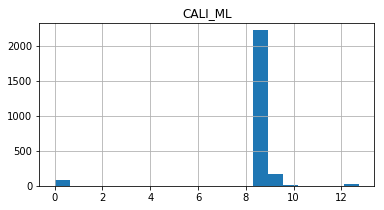

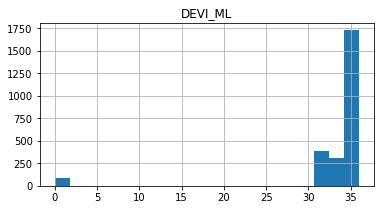

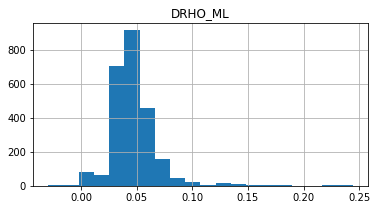

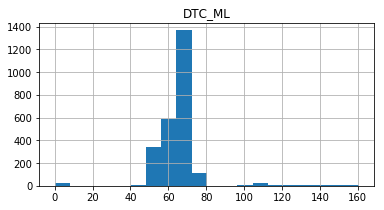

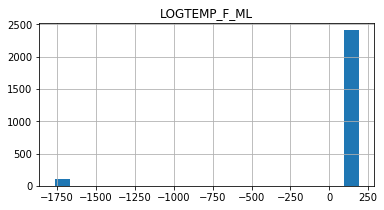

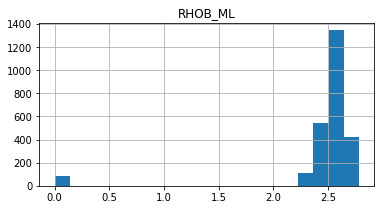

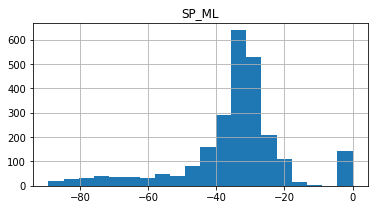

In [65]:
logs_to_correct = ['CALI_ML', 'DEVI_ML', 'DRHO_ML', 'DTC_ML','LOGTEMP_F_ML', 'RHOB_ML', 'SP_ML']
for log in logs_to_correct:
    ax = log_data_df.hist(column=log, figsize=(6,3), bins=20)

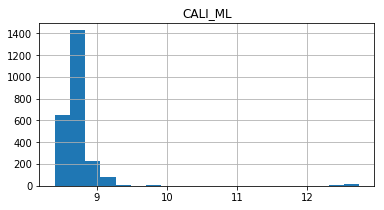

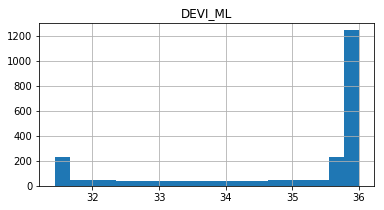

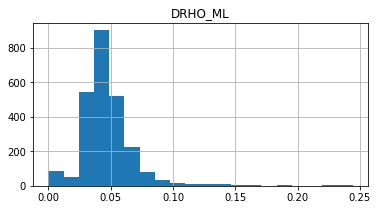

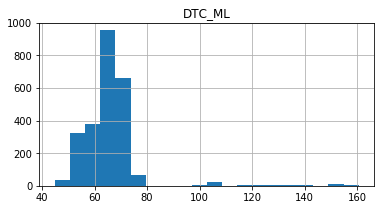

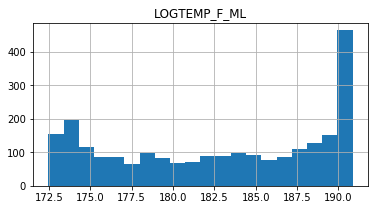

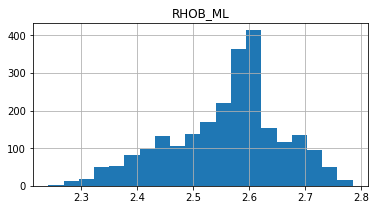

In [66]:
# correct logs inplace
log_data_df['CALI_ML'].where(log_data_df['CALI_ML']>=8, other=np.nan, inplace=True)
log_data_df['DEVI_ML'].where(log_data_df['DEVI_ML']>=30, other=np.nan, inplace=True)
log_data_df['DRHO_ML'].where(log_data_df['DRHO_ML']>=0, other=np.nan, inplace=True)
log_data_df['DTC_ML'].where(log_data_df['DTC_ML']>=30, other=np.nan, inplace=True)
log_data_df['LOGTEMP_F_ML'].where(log_data_df['LOGTEMP_F_ML']>=0, other=np.nan, inplace=True)
log_data_df['RHOB_ML'].where(log_data_df['RHOB_ML']>=2, other=np.nan, inplace=True)

logs_to_correct = ['CALI_ML', 'DEVI_ML', 'DRHO_ML', 'DTC_ML','LOGTEMP_F_ML', 'RHOB_ML']
for log in logs_to_correct:
    ax = log_data_df.hist(column=log, figsize=(6,3), bins=20)

In [67]:
log_data_df.describe()

,AZIM_ML,CACO3_ML,CALI_ML,CGR_ML,CPI_BVW_ML,CPI_BVW_DF_ML,CPI_BVWSXO_ML,CPI_CGR_ML,CPI_DOL_ML,CPI_LIM_ML,CPI_PHIE_ML,CPI_PHIND_ML,CPI_SHL_ML,CPI_SW_ML,CPI_SW_DF_ML,CPI_SXO_ML,DEVI_ML,DRHO_ML,DTC_ML,GR_ML,H2S_ML,HC_SHOWS_ML,IC4_ML,IC5_ML,LITH_ML,LLD_ML,LLS_ML,LOGTEMP_F_ML,LOSSES_ML,LWD_GR_RT_ML,LWD_RES_D_MEM_ML,LWD_RES_D_RT_ML,LWD_RES_S_MEM_ML,LWD_RES_S_RT_ML,MGCO3_ML,MM1_VCL_ML,MM2_LIM_ML,MM3_DOL_ML,MM4_ANH_ML,MM5_KER_ML,MM6_SAND_ML,MM7_PYR_ML,MM8_HAL_ML,MRES_ML,MTIN_ML,MTOT_ML,MW_IN_ML,MW_OUT_ML,NC4_ML,NC5_ML,NPHI_ML,PEF_ML,POTA_ML,RHOB_ML,ROP_ML,SGR_ML,SP_ML,TG_ML,THOR_ML,URAN_ML,WOB_ML
count,2507.000000,2507.000000,2428.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2416.000000,2501.000000,2485.000000,2507.000000,2507.0,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2407.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2426.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000
mean,288.428070,53.411628,8.744034,10.598542,0.070701,0.089858,0.083701,5.446244,0.351172,0.391237,0.103974,0.117317,0.088199,0.780698,0.883447,0.843309,34.765088,0.047030,65.743236,27.798747,0.0,0.262066,79.464006,88.267029,1.052596,154.081651,67.463916,182.797288,0.034501,29.005866,5.375734,82.540448,4.875881,59.426895,30.150858,0.090337,0.483625,0.837430,0.837430,0.837430,0.837430,0.837430,0.837430,12.983939,44.412162,49.567253,8.957308,9.027995,96.881383,98.126685,0.127759,3.978234,0.367868,2.559038,6.616975,28.363581,-35.068575,0.384171,0.710338,2.116066,11.759239
std,55.995460,26.104810,0.434147,9.056490,0.043495,0.070489,0.059532,5.898185,0.370022,0.370709,0.079330,0.071708,0.090335,0.294636,0.288336,0.262459,1.598603,0.021748,11.239947,13.660329,0.0,0.439846,121.819605,77.250546,0.942092,1612.085779,120.357908,6.275521,3.276352,14.090720,10.678161,97.723352,9.409993,58.882363,27.019128,0.092362,0.427974,0.225752,0.225752,0.225752,0.225752,0.225752,0.225752,24.120722,3.696443,3.444716,0.325300,0.320047,146.209567,85.325645,0.077392,1.116295,0.336707,0.100604,3.225689,13.760770,16.134504,0.486763,0.544598,1.552933,4.875581
min,0.000000,0.000000,8.400334,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,31.434872,0.000000,44.760520,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,172.459150,-56.795276,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.242219,0.000000,0.000000,-89.291263,0.000000,0.000000,0.000000,0.000000
25%,298.529085,30.000000,8.604054,3.274089,0.041685,0.041685,0.041685,1.470399,0.000000,0.000000,0.043513,0.074130,0.012869,0.550362,1.000000,0.786995,33.692739,0.035935,60.860819,20.183374,0.0,0.000000,0.788386,0.000000,0.000000,10.830072,12.550405,176.684181,-0.820000,21.750000,0.000000,9.592126,0.000000,9.166142,6.000000,0.013229,0.030337,0.809709,0.809709,0.809709,0.809709,0.809709,0.809709,2.407196,42.078317,47.148466,8.844093,8.932832,63.141732,0.000000,0.078636,3.190841,0.084137,2.497599,4.528978,20.524228,-38.903778,0.126161,0.376724,0.989069,7.478307
50%,298.990000,62.000000,8.695200,7.277528,0.068578,0.065654,0.069467,3.684339,0.129639,0.293425,0.076970,0.093870,0.052768,0.998675,1.000000,0.999185,35.799800,0.043898,66.164803,26.477347,0.0,0.000000,87.023620,112.805118,1.000000,50.722361,37.927923,183.603245,0.000000,27.652835,0.000000,54.709606,0.000000,45.135039,16.000000,0.054007,0.386384,0.914708,0.914708,0.914708,0.914708,0.914708,0.914708

In [68]:
log_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2507 entries, 0 to 2506
Data columns (total 61 columns):
AZIM_ML             2507 non-null float64
CACO3_ML            2507 non-null float64
CALI_ML             2428 non-null float64
CGR_ML              2507 non-null float64
CPI_BVW_ML          2507 non-null float64
CPI_BVW_DF_ML       2507 non-null float64
CPI_BVWSXO_ML       2507 non-null float64
CPI_CGR_ML          2507 non-null float64
CPI_DOL_ML          2507 non-null float64
CPI_LIM_ML          2507 non-null float64
CPI_PHIE_ML         2507 non-null float64
CPI_PHIND_ML        2507 non-null float64
CPI_SHL_ML          2507 non-null float64
CPI_SW_ML           2507 non-null float64
CPI_SW_DF_ML        2507 non-null float64
CPI_SXO_ML          2507 non-null float64
DEVI_ML             2416 non-null float64
DRHO_ML             2501 non-null float64
DTC_ML              2485 non-null float64
GR_ML               2507 non-null float64
H2S_ML              2507 non-null float64
HC_SHOWS_ML

In [69]:
log_data_df.dropna(axis=0, how='any', inplace=True)

In [70]:
log_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2394 entries, 7 to 2406
Data columns (total 61 columns):
AZIM_ML             2394 non-null float64
CACO3_ML            2394 non-null float64
CALI_ML             2394 non-null float64
CGR_ML              2394 non-null float64
CPI_BVW_ML          2394 non-null float64
CPI_BVW_DF_ML       2394 non-null float64
CPI_BVWSXO_ML       2394 non-null float64
CPI_CGR_ML          2394 non-null float64
CPI_DOL_ML          2394 non-null float64
CPI_LIM_ML          2394 non-null float64
CPI_PHIE_ML         2394 non-null float64
CPI_PHIND_ML        2394 non-null float64
CPI_SHL_ML          2394 non-null float64
CPI_SW_ML           2394 non-null float64
CPI_SW_DF_ML        2394 non-null float64
CPI_SXO_ML          2394 non-null float64
DEVI_ML             2394 non-null float64
DRHO_ML             2394 non-null float64
DTC_ML              2394 non-null float64
GR_ML               2394 non-null float64
H2S_ML              2394 non-null float64
HC_SHOWS_ML

In [74]:
# check output
log_data_df.head()

,AZIM_ML,CACO3_ML,CALI_ML,CGR_ML,CPI_BVW_ML,CPI_BVW_DF_ML,CPI_BVWSXO_ML,CPI_CGR_ML,CPI_DOL_ML,CPI_LIM_ML,CPI_PHIE_ML,CPI_PHIND_ML,CPI_SHL_ML,CPI_SW_ML,CPI_SW_DF_ML,CPI_SXO_ML,DEVI_ML,DRHO_ML,DTC_ML,GR_ML,H2S_ML,HC_SHOWS_ML,IC4_ML,IC5_ML,LITH_ML,LLD_ML,LLS_ML,LOGTEMP_F_ML,LOSSES_ML,LWD_GR_RT_ML,LWD_RES_D_MEM_ML,LWD_RES_D_RT_ML,LWD_RES_S_MEM_ML,LWD_RES_S_RT_ML,MGCO3_ML,MM1_VCL_ML,MM2_LIM_ML,MM3_DOL_ML,MM4_ANH_ML,MM5_KER_ML,MM6_SAND_ML,MM7_PYR_ML,MM8_HAL_ML,MRES_ML,MTIN_ML,MTOT_ML,MW_IN_ML,MW_OUT_ML,NC4_ML,NC5_ML,NPHI_ML,PEF_ML,POTA_ML,RHOB_ML,ROP_ML,SGR_ML,SP_ML,TG_ML,THOR_ML,URAN_ML,WOB_ML
7,301.488084,48.0,12.243157,12.248065,0.0,0.0,0.0,17.927622,0.0,0.700510,0.223504,0.0,0.075986,0.0,0.0,0.0,31.437079,0.239303,76.838150,33.765295,0.0,0.0,0.0,0.0,0.0,0.454337,3.963143,172.486008,0.0,67.107244,57.629921,0.172126,4.515748,4.292520,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.255142,51.411890,56.709882,10.850197,10.884843,56.625984,0.0,0.233511,4.673771,0.276266,2.501506,5.957913,33.206935,-31.384525,0.300253,1.141142,1.998021,9.363583
8,301.485484,48.0,12.375220,12.121865,0.0,0.0,0.0,17.352776,0.0,0.703687,0.221613,0.0,0.074699,0.0,0.0,0.0,31.437379,0.205845,77.549677,37.868927,0.0,0.0,0.0,0.0,0.0,0.824660,4.243939,172.538102,0.0,66.370866,22.579449,0.151417,4.594331,4.655906,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.305255,49.691890,56.182382,10.882697,10.922343,58.375984,0.0,0.231428,4.643341,0.288945,2.494517,5.105413,38.001427,-30.587285,0.394146,1.104514,2.604340,9.066083
9,301.482884,48.0,12.371453,12.983535,0.0,0.0,0.0,14.950129,0.0,0.686339,0.229955,0.0,0.083706,0.0,0.0,0.0,31.437772,0.118570,78.401480,44.309319,0.0,0.0,0.0,0.0,0.0,3.026545,4.686643,172.521745,0.0,68.390551,5.312598,0.122126,3.624409,4.271181,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.860569,47.971890,55.654882,10.915197,10.959843,60.125984,0.0,0.241056,4.739324,0.364802,2.486567,4.252913,46.266597,-28.226277,0.488046,1.138408,3.794035,8.768583
10,301.480284,48.0,12.423489,14.720490,0.0,0.0,0.0,15.049869,0.0,0.664187,0.233852,0.0,0.101961,0.0,0.0,0.0,31.438079,0.076700,78.357008,53.560631,0.0,0.0,0.0,0.0,0.0,4.882773,4.948124,172.501803,0.0,67.537244,4.032756,0.101417,3.057559,3.478110,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.393461,46.251890,55.127382,10.947697,10.997343,61.875984,0.0,0.247468,4.809888,0.510985,2.490924,3.400413,57.100235,-28.336030,0.581853,1.172047,5.345615,8.471083
11,301.477777,48.0,12.451100,17.943774,0.0,0.0,0.0,18.478241,0.0,0.635283,0.228990,0.0,0.135727,0.0,0.0,0.0,31.438379,0.044546,78.696496,72.999840,0.0,0.0,0.0,0.0,0.0,5.873472,5.519364,172.540631,0.0,50.159527,4.354488,1.744567,3.549606,3.531496,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.485467,46.173391,55.093066,10.943775,10.990709,59.832052,0.0,0.246878,4.852794,0.742462,2.532646,3.953228,74.763327,-28.865850,0.536469,0.820865,7.182702,9.648583


In [75]:
# reset index
log_data_df.reset_index(drop=True, inplace=True)
log_data_df.head()

,AZIM_ML,CACO3_ML,CALI_ML,CGR_ML,CPI_BVW_ML,CPI_BVW_DF_ML,CPI_BVWSXO_ML,CPI_CGR_ML,CPI_DOL_ML,CPI_LIM_ML,CPI_PHIE_ML,CPI_PHIND_ML,CPI_SHL_ML,CPI_SW_ML,CPI_SW_DF_ML,CPI_SXO_ML,DEVI_ML,DRHO_ML,DTC_ML,GR_ML,H2S_ML,HC_SHOWS_ML,IC4_ML,IC5_ML,LITH_ML,LLD_ML,LLS_ML,LOGTEMP_F_ML,LOSSES_ML,LWD_GR_RT_ML,LWD_RES_D_MEM_ML,LWD_RES_D_RT_ML,LWD_RES_S_MEM_ML,LWD_RES_S_RT_ML,MGCO3_ML,MM1_VCL_ML,MM2_LIM_ML,MM3_DOL_ML,MM4_ANH_ML,MM5_KER_ML,MM6_SAND_ML,MM7_PYR_ML,MM8_HAL_ML,MRES_ML,MTIN_ML,MTOT_ML,MW_IN_ML,MW_OUT_ML,NC4_ML,NC5_ML,NPHI_ML,PEF_ML,POTA_ML,RHOB_ML,ROP_ML,SGR_ML,SP_ML,TG_ML,THOR_ML,URAN_ML,WOB_ML
0,301.488084,48.0,12.243157,12.248065,0.0,0.0,0.0,17.927622,0.0,0.700510,0.223504,0.0,0.075986,0.0,0.0,0.0,31.437079,0.239303,76.838150,33.765295,0.0,0.0,0.0,0.0,0.0,0.454337,3.963143,172.486008,0.0,67.107244,57.629921,0.172126,4.515748,4.292520,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.255142,51.411890,56.709882,10.850197,10.884843,56.625984,0.0,0.233511,4.673771,0.276266,2.501506,5.957913,33.206935,-31.384525,0.300253,1.141142,1.998021,9.363583
1,301.485484,48.0,12.375220,12.121865,0.0,0.0,0.0,17.352776,0.0,0.703687,0.221613,0.0,0.074699,0.0,0.0,0.0,31.437379,0.205845,77.549677,37.868927,0.0,0.0,0.0,0.0,0.0,0.824660,4.243939,172.538102,0.0,66.370866,22.579449,0.151417,4.594331,4.655906,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.305255,49.691890,56.182382,10.882697,10.922343,58.375984,0.0,0.231428,4.643341,0.288945,2.494517,5.105413,38.001427,-30.587285,0.394146,1.104514,2.604340,9.066083
2,301.482884,48.0,12.371453,12.983535,0.0,0.0,0.0,14.950129,0.0,0.686339,0.229955,0.0,0.083706,0.0,0.0,0.0,31.437772,0.118570,78.401480,44.309319,0.0,0.0,0.0,0.0,0.0,3.026545,4.686643,172.521745,0.0,68.390551,5.312598,0.122126,3.624409,4.271181,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.860569,47.971890,55.654882,10.915197,10.959843,60.125984,0.0,0.241056,4.739324,0.364802,2.486567,4.252913,46.266597,-28.226277,0.488046,1.138408,3.794035,8.768583
3,301.480284,48.0,12.423489,14.720490,0.0,0.0,0.0,15.049869,0.0,0.664187,0.233852,0.0,0.101961,0.0,0.0,0.0,31.438079,0.076700,78.357008,53.560631,0.0,0.0,0.0,0.0,0.0,4.882773,4.948124,172.501803,0.0,67.537244,4.032756,0.101417,3.057559,3.478110,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.393461,46.251890,55.127382,10.947697,10.997343,61.875984,0.0,0.247468,4.809888,0.510985,2.490924,3.400413,57.100235,-28.336030,0.581853,1.172047,5.345615,8.471083
4,301.477777,48.0,12.451100,17.943774,0.0,0.0,0.0,18.478241,0.0,0.635283,0.228990,0.0,0.135727,0.0,0.0,0.0,31.438379,0.044546,78.696496,72.999840,0.0,0.0,0.0,0.0,0.0,5.873472,5.519364,172.540631,0.0,50.159527,4.354488,1.744567,3.549606,3.531496,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.485467,46.173391,55.093066,10.943775,10.990709,59.832052,0.0,0.246878,4.852794,0.742462,2.532646,3.953228,74.763327,-28.865850,0.536469,0.820865,7.182702,9.648583


#### clean well data, steps required: 
- select curves for analysis - done
- filter to get subset based on depth (Shiranish to TD) - done
- get into pd.DataFrame for easier manipulation - done
- dropna - done
- check stats/distributions and correct as needed - done
- n.b. will need P32 curve for output (need to calc) (same sampling as training data)
- output to array so that can be split in X, y for ML

In [71]:
# calc P32 curve on same sampling

### 9. Static Fracture Analysis

<hr>

![agile_logo](agile_logo_size_50.jpg)
<p style="text-align:center;color:gray">© Agile Geoscience 2018. Licensed CC-BY.</p>
</hr>